Any Player Attribute listed with shorthand means that vibes are used in it, anything without is the raw attribute.

Season 12-18: 0.6 - 0.4*ruth + 0.35*combatting + 0.2*dfc["ballpark_viscosity"]
Combatting is the following formula: 0.25 * (dfc["thwack"] + dfc["musc"] + dfc["div"] + dfc["invpath"])
Invpath refers to 1 - Patheticism
Season 19: 0.5 - 0.2*dfc["ruthvibe"] + 0.35*dfc["combatting"] + 0.2*dfc["ballpark_viscosity"]
# Season 19 needs multiplier and hype handling done

In [344]:
import load

df = load.data("swing-on-strike", season=18)

df["ruth_scaled"] = load.player_attribute(
        # These values are mandatory: the dataframe, the player role, and the attribute
        df, 'pitcher', 'ruthlessness',
        # These are all optional, and the default values are as they appear here
        vibes=True, mods=True, items=True, broken_items=True
    )


df["musc_scaled"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)

df["thwack_scaled"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)

df["div_scaled"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)

df["path_scaled"] = load.player_attribute(df, 'batter', 'patheticism', vibes=False, mods=False, items="negative", broken_items=True)

    # center=True is the default
df["viscosity"] = load.stadium_attribute(df, 'viscosity', center=False)

In [345]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [346]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    #if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        #if not row["top_of_inning"]:
            #mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "TRAVELING" in pm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in pm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["runner_name"]].isna().any():
    # row["runner_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.05
    #if "TRAVELING" in bm:
        #if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            #mul += 0.05
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "HIGH_PRESSURE" in bm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "AFFINITY_FOR_CROWS" in bm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["runner_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul, attrs


def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul

In [347]:
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")

In [420]:
df = df.copy()
df = df[(df["batter_mul"] == 1) & (df["pitcher_mul"] == 1) & (df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)] 


In [421]:
dfc = df.copy()
for exclude_mod in ["LATE_TO_PARTY"]:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["O_NO", "0", "LATE_TO_PARTY"]:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    
dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

len(dfc)

21052

In [422]:
#Currently Manually doing invpath to properly handle the batter mul. Negative Stats :angryclark:

dfc["invpath"] = (1 - (dfc["path_scaled"] / dfc["batter_mul"])) * (1 + 0.2 * dfc["batter_vibes"])
dfc["combatting"] = (0.25 * (dfc["thwack_scaled"] + dfc["musc_scaled"] + dfc["div_scaled"] + dfc["invpath"]))


In [423]:
X = dfc[
    [
        "roll",
        "passed",
        "ruth_scaled",
        "viscosity",
        "combatting",
        "batting_team_hype"
        #"pitching_team_hype"
    ]
].copy()
#X = X[X["batting_team_hype"] == 0]
#X = X[X["pitching_team_hype"] == 0]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.5
pins = [ (-0.2, "ruth_scaled"), 
(0.35, "combatting"),
(0.2, "viscosity"),
#(-0.115, "pitching_team_hype"),
#(0.11, "batting_team_hype")
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[ 6351     3]
 [    0 14698]]
3 outliers
0.9998574957248717
0.5


[(1.0, 'roll'), (-0.0, 'batting_team_hype')]

In [424]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

6354
14698


In [425]:
#0.5 - 0.2*dfc["ruthvibe"] + 0.35*dfc["combatting"] + 0.2*dfc["ballpark_viscosity"]
dfc["threshold"] = 0.5 - 0.2*dfc["ruth_scaled"] + 0.35*dfc["combatting"] + 0.2*dfc["viscosity"]

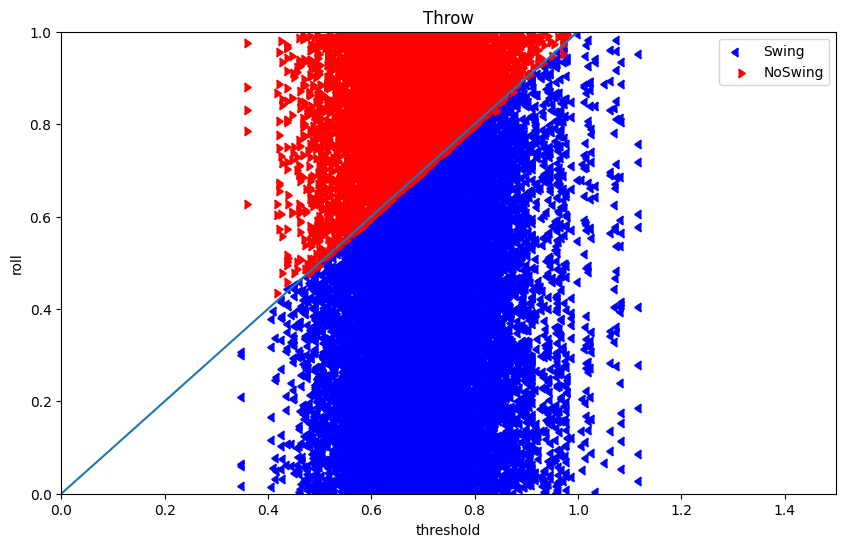

In [426]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Swing", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoSwing", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Throw")
ax.set_xlim([0.0, 1.5])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,event_type,roll,threshold,season,path_scaled,batter_mods,batting_team_mods,pitcher_mods,pitching_team_mods,batter_name,pitcher_name,weather,day,game_id,play_count
113230,-0.013536,StrikeLooking,0.951730,0.965266,18,-0.105587,REVERBERATING;TRAVELING,SINKING_SHIP;LIFE_OF_PARTY;PARTY_TIME,,FIREPROOF;PARTY_TIME,Don Mitchell,Leach Ingram,Weather.BLOODDRAIN,96,32c00ad2-202b-42da-9230-970b81f4f882,241
24793,-0.009350,StrikeLooking,0.827878,0.837229,18,0.001000,ALTERNATE;FIRE_EATER,SHAME_GIVER,,SINKING_SHIP,Malik Destiny,Yosh Carpenter,Weather.FEEDBACK,22,f3b2e472-520d-450b-9ebd-793abef7ca20,130
12637,-0.000172,StrikeLooking,0.781891,0.782064,18,-0.103201,REVERBERATING;TRAVELING,SINKING_SHIP,OVERUNDER,O_NO,Don Mitchell,Curry Aliciakeyes,Weather.POLARITY_MINUS,14,7eb9a7e3-cc74-4ac6-838b-3e527c1fca05,113


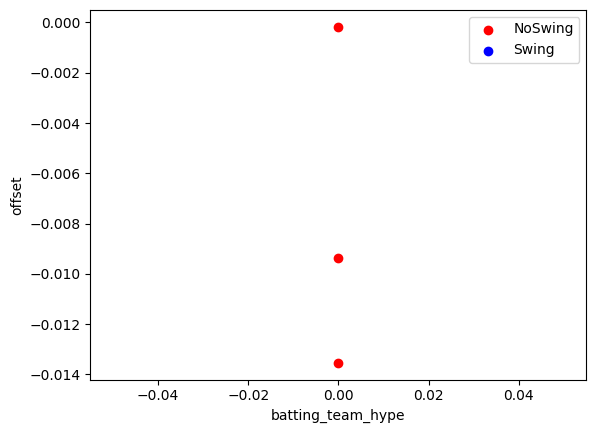

In [427]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "batting_team_hype"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="NoSwing")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Swing")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset","event_type",
       "roll", "threshold", "season", "path_scaled", "batter_mods", "batting_team_mods", "pitcher_mods", "pitching_team_mods",
       "batter_name", "pitcher_name", "weather", "day",  "game_id", "play_count"]].sort_values('offset')


In [143]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].max())

0.997729089847168
0.9999947256987208
